In [1]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='serif', size=18)


GRIEVANCE_THRESHOLD = 0.5   # Arbitrary
N_STUDENTS          = 500 # Consider a system with 500 students

# Maximum time to run for
TIME_LIMIT = 100

What follows is the basic "agent" in the model that all classes will be based on

The important idea here is that Agents have their update() function called every timestep, and in that function the Agent needs to evaluate other Agents, and then consider any actions it may have to take.

In [2]:
class Agent(object):
    
    def __init__(self):
        pass
    
    def connect(self, **kwargs):
        """
        In this method, this Agent connects itself with other agents
        
        **kwargs is a dictionary where elements can be accessed like 
            other_agent = kwargs['other_agent']
        
        @kwargs
            other_agent - some other Agent to be connected to this Agent
        """
        pass
    
    def consider_action(self):
        """
        In this method, this Agent considers its parameters and decides whether 
        or not to take any actions it might have
        """
        pass
    
    
    def update(self):
        """
        In this method, this Agent looks at other Agents it is connected to to change its parameters
        """
        self.consider_action()

The basic student class is a fairly complicated Agent, but I can break down its parts.

First, the Student is created with a few base values associated with "class" or socioeconomic background. These are
1. hardship_base - the base experience of hardship (negative is more wealthy)
2. tuition_value - the amount that this Student cares about tuition ( negative means more tuition is bad )
3. dev_value     - the amount that this Studeny cares about development ( positive means more development is good)

Second, there is only one action the Student can take, and that is to drop out. They will do this based on their grievance, which is a function of their experienced hardship and the perceived legitimacy that the university has with them.

The grievance is calculated during update() by adding the base hardship to the tuition to get the experienced hardship. The experienced hardship is multiplied by (1 - legitimacy). If it exceeds an arbitrary value, the Student drops out.

The legitimacy of the university comes from the Discourse that the student partakes in. 

In this basic implementation of the Student class, there is no student-student interaction or resistance other than simply dropping out. Students each participate in 1 discourse, which is their connection to other students. You could program an increased number of discourses, in which case perhaps students take an average. 

In [3]:
 class Student(Agent):
    
    def __init__(self, hardship_base, tuition_value, dev_value):
        """
        Create the student
        """
        self.paying        = True           # whether or not student is attending university
        
        self.hardship_base = hardship_base  # represents class background
        self.tuition_value = tuition_value  # represents value placed on low tuition
        self.dev_value     = dev_value      # represents value based on university development
        
        self.hardship   = 0  # represents total experienced hardship
        self.legitimacy = 1  # represents perceived legitimacy of university
        self.grievance  = 0  # represents total unhappiness with university
    
    def connect(self,  **kwargs):
        """
        Connect this Student to their Discourse, Faculty, and University
        
        @kwargs
            university - the University Agent this Student is part of
            discourse  - the Discourse Agent this Student is part of
            faculty    - the Faculty Agent this Student is taught by
        """
        self.university = kwargs['university']
        self.discourse  = kwargs['discourse']
        self.faculty    = kwargs['faculty']
        
    def consider_payment(self):
        """
        If the grievance is greater than a threshold, drop out
        """
        if self.grievance > GRIEVANCE_THRESHOLD:
            self.paying = False
        else:
            self.paying = True
            
    def update(self):
        """
        Update the Student's parameters to reflect changes in tuition and discourse
        """
            
        # Hardship is just base hardship from wealthyness + cost of school
        self.hardship   = self.hardship_base + self.university.tuition
        
        # Legitimacy comes from the discourse that the student partakes in
        self.legitimacy = self.discourse.legitimacy
        
        # Grievance comes from how bad things are modified by how legitimate
        # the student perceives the university to be
        self.grievance  = self.hardship * (1 - self.legitimacy)
        
        self.consider_payment()
    
    

The basic implementation of the Discourse Agent is quite simple: when updating, the Discourse takes a group of students and computes an independent legitimacy for each one, then averages it. 

You could imagine a situation where different Students are associated with different Discourses, and also where there is a feedback onto the student, where the Discourse changes the values of the Students. For now, it doesn't - it simply averages all of the students together. 

The legitimacy is computed by multiplying the value the student has by the paramter from the university in question. A larger number means more legitimacy. In this case, there are two parameters to consider:
1. tuition - student.tuition_value is always negative because no one wants to pay more tuition
2. development - student.dev_value may be positive or negative depending on what that student prioritizes as a student, and also what development means practically for the student experience (consider the effect on humnaities students when the university diverts funding into an engineering department, for example)

In [4]:
class Discourse(Agent):
    
    def __init__(self):
        """
        Create the discourse
        """
        self.legitimacy = 1 
    
    def connect(self,  **kwargs):
        """
        Connect this Discourse to the group of students participating as well as the University
        
        @kwargs
            university - the University Agent this discourse is discussing
            students   - list of Student Agents which are participating in this discourse
            faculty    - the Faculty Agent this discourse is connected to
        """
        self.students = kwargs['students']
        self.university = kwargs['university']
        self.faculty = kwargs['faculty']
        
    def update(self):
        """
        Update the discourse to represent tuition changes
        
        legitimacy is the average of the students value of development * amount of development
        plus the students value of tuition (always negative) * tuition amount
        
        So more development usually means more legitimacy, and more tuition usually means less. 
        
        @kwargs
            students   - a list of Student objects
            university - the University object being attended
        """
        legitimacies = []
        
        for student in self.students:
            legitimacies.append(student.dev_value        * self.university.development 
                                 + student.tuition_value * self.university.tuition    )
        
        self.legitimacy = np.mean(legitimacies)
        
    

The basic University Agent has a few parameters to be concenred with.
1. tuition - how much money it gets from each student
2. development - amount of invested money in things like buildings, departments, etc
3. revenue - how much money the university is bringing in
4. revenue-threshold - something akin to an operating cost.

The basic dynamic is this: if the average revenue (based on some memory) is less than the threshold, the tuition must be raised so that more revenue can be created. This is like justifying a fee hike because the current revenue isnt meeting the cost of operating the university.

If the revenue is greater than the threshold, it is invested in development. However, this investment also causes an increase in costs (and thus the revenue_threshold).

Revenue may drop if students drop out, so this will often lead to a positive feedback as the tuition is raised to cover those students who drop out. Meanwhile, only the wealthier students remain behind. 

So, you can see that the tuition never goes down. I justify this by saying that, historically, it hasn't!

In [5]:
class University(Agent):
    
    def __init__(self):
        """
        Create the university
        """
        self.tuition           = 0  # Cost of attendance
        self.development       = 0  # Degree of development, such as construction
        self.revenue_threshold = 0  # Like an operating cost
        self.memory_length     = 5  # Number of timesteps where the university remembers revenue
        
        self.revenue = None
        self.revenue_memory = []
    
    def connect(self,  **kwargs):
        """
        Connect this University to the group of students attending
        
        @kwargs
            students - list of Student Agents (the student body of the university)
            faculty  - the Faculty Agent of the university
        """
        self.students = kwargs['students']
        self.faculty  = kwargs['faculty']
        
    def consider_tuition(self):
        """
        Consider whether the university either raises tuition or develops itself a bit
        """
        
        # If the average of revenue memory is less than the preferred amount, raise tuition
        if np.mean(self.revenue_memory) < self.revenue_threshold:
            self.tuition    = self.tuition + 0.02
            
        # Otherwise, develop the university and increase operating costs
        # by a little bit. Will need to tune these numbers. 
        else:
            self.development       = self.development + 0.01
            self.revenue_threshold = self.revenue_threshold + N_STUDENTS * 0.01
            
    def update(self):
        """
        Update the university to represent changes in number of students
        """
        
        # Determine the number of paying students
        n_paying_students = np.sum([int(student.paying) for student in self.students])
        
        # Determine revenue from the number of paying students
        self.revenue = self.tuition * n_paying_students  
        
        # Update the memory of the university
        if len(self.revenue_memory) > self.memory_length:
            self.revenue_memory.pop(0)
        self.revenue_memory.append(self.revenue)
        
        self.consider_tuition()
        

The Faculty Agent class is a stub. Currently Faculty does nothing, but you could program in some dynamics to see if they do anything. What actions might they take? Perhaps teach classes about why the neoliberal university is bad. 

In [6]:
class Faculty(Agent):
    
    def __init__(self):
        """
        Create the faculty and their parameters
        """
    
    def connect(self, **kwargs):
        """
        Connect this faculty to the student body and the university
        """
        self.students   = kwargs['students']
        self.university = kwargs['university']
    
    def consider_action(self):
        """
        Consider whether the faculty will take some action
        """
        pass
    
    def update(self):
        """
        Update the faculty's parameters based on the other Agent's parameters
        """
        pass

Explanation of instantiation code

Basically, this should reflect the class stratification of the University. 
1. We have students from rich families that basically like neoliberalism and think the development is well worth the cost of raised tuition.
2. We have poor students that don't care at all. 
3. We have international students who represent specific classes internationally. 
4. We have students who will experience different sides of the university -i.e. STEM versus humanities. For whom "development" means budget cuts.
    
Currently all of these dynamics are not modeled, but may come in here where different student populations have different parameter statistics

In [7]:
# Instantiate the student population
students = []
for i in range(N_STUDENTS):
    
    # Create a hardship base from an even distribution between -0.5 and 0.5
    hardship_base = np.random.rand(1) - 0.5
    
    # Create tuition value between 0 and -1 (i.e. tuition is always bad)
    # Create development value between -0.1 and 0.4 (i.e. development is usually good)
    tuition_value = -1*np.random.rand(1)
    dev_value     =  0.5*np.random.rand(1) - 0.1
    
    students.append(Student(hardship_base, tuition_value, dev_value))
    
# Instantiate a few discourses
discourses = [Discourse(), Discourse(), Discourse()]

# Instantiate the university
university = University()

# Instantiate a faculty
faculty = Faculty()


This code connects up the Agents to each other, so they can evaluate the other's situations and update their parameters

In [8]:
university.connect(students=students, faculty=faculty)
faculty.connect(students=students, university=university)

# Create 3 groups of student, of different sizes
student_groups = [students[0:100], students[100:200], students[200:500]]

# Then connect the 3 discourses to the 3 groups
for discourse, group in zip(discourses, student_groups):
    
    discourse.connect(students=group, university=university, faculty=faculty)
    for student in group:
        student.connect(discourse=discourse, university=university, faculty=faculty)

Start the simulation

For each time step, advance time, then update each agent.

Finally, get any information from agents that we are interested in charting over time. 

In [9]:
time = 0

n_students  = []
tuition     = []
development = []
revenue_avg = []

while time < TIME_LIMIT:
    
    # Advance time
    time = time + 1
    
    # Update every agent
    for student in students:
        student.update()
    for discourse in discourses:
        discourse.update()
    university.update()
    faculty.update()
    
    # Get any information we are interested in plotting later.     
    n_students.append(np.sum([int(student.paying) for student in students]))
    tuition.append(university.tuition)
    development.append(university.development)
    revenue_avg.append(np.mean(university.revenue_memory))
    

Make some plots
1. the attendance of the university over time.
2. the running average university revenue over time
3. the tuition and development of the university over time

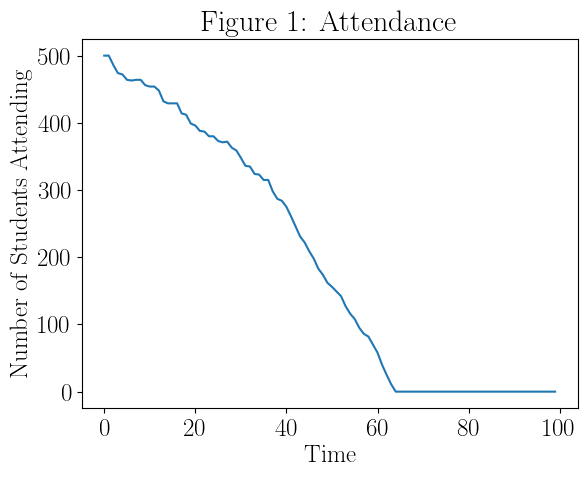

In [10]:
plt.figure()
plt.plot(np.arange(0, TIME_LIMIT, 1), n_students)
plt.xlabel("Time")
plt.ylabel("Number of Students Attending")
plt.title("Figure 1: Attendance")
plt.show()

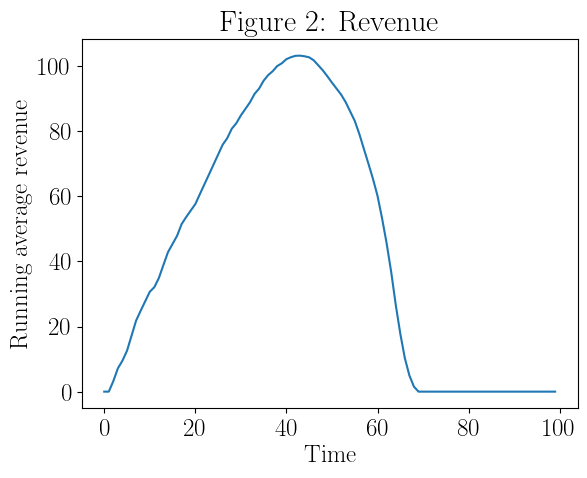

In [11]:
plt.figure()
plt.plot(np.arange(0, TIME_LIMIT, 1),revenue_avg)
plt.xlabel("Time")
plt.ylabel("Running average revenue")
plt.title("Figure 2: Revenue")
plt.show()

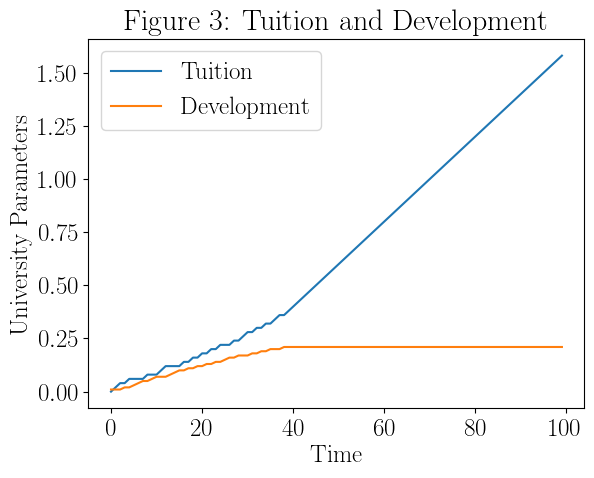

In [12]:
plt.figure()
plt.plot(np.arange(0, TIME_LIMIT, 1), tuition, label='Tuition')
plt.plot(np.arange(0, TIME_LIMIT, 1), development, label='Development')
plt.xlabel("Time")
plt.ylabel("University Parameters")
plt.title("Figure 3: Tuition and Development")
plt.legend()
plt.show()

So clearly under this system it is only a matter of time before the university fails and all students drop out, because the costs always go up (which, to be fair, they do!) 

But, even though tuition goes up, folks are willing to pay more these days than they were 50 years ago. Sounds like the tuition_value has grown closer to 0 (i.e. students dislike tuition less) - how might we model that?

A few dynamical notes
1. There are two modes: one where the tuition and development are increasing together (i.e. more development means more fees, and this is ok because more development means more legitimacy, but people are still dropping out) and one where the tuition goes up rapidly to account for students dropping out.Therefore, even if you value development much more than you care about tuition, it will still be too much in the end. 
2. The number of students always drops - but in reality, the number of students is increasing, with student loans making up the economic difference. This might be modeled as another object class - the "economy", which can make the student base hardship more or less bad, depending on group.
3. I think this points to a fundamental question overall, which is: why are students willing to pay more under normal conditions? Because covid-19 will either challenge or not challenge that reason. 
4. I think another dynamic from covid-19 will be to decrease the "perceived" development of the university - after all, what are the buildings good for if you're taking all your classes online?